# Assignment 4

Isaiah D. Murray (idm22@cornell.edu)

Daan van der Zwagg (dv239@cornell.edu)

#### In this assignment, we will conclude our analysis of whether the stop and frisk policy was racially discriminatory, but from a very different angle than our previous mapping analysis. We will rely heavily on logistic regression and regularized regression, as discussed in class. 

# Data processing (5 points)

First we need to do some data processing for consistency with previous of analysis of stop_and_frisk data. Load in the data "sqf_sample" and filter for stops between 2008 and 2012 (including both 2008 and 2012 in your sample). Filter for stops of white, Black, and Hispanic pedestrians using the suspect_race column. (5 points)


In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# read in csv
sqf_sample = pd.read_csv("sqf_sample.csv")

In [3]:
data = sqf_sample

In [4]:
# check shape
print (data.shape)

(408615, 89)


In [5]:
# check columns
print (data.columns)

Index(['year', 'date', 'time', 'precinct', 'xcoord', 'ycoord', 'serial',
       'radio_run', 'inside_outside', 'location_housing', 'observation_period',
       'suspected_crime', 'stop_length', 'identification', 'reason_explained',
       'others_stopped', 'arrested', 'arrested_reason', 'summons_issued',
       'officer_uniform', 'officer_verbal', 'officer_shield', 'frisked',
       'searched', 'extra_reports', 'force_hands', 'force_wall',
       'force_ground', 'force_drawn', 'force_pointed', 'force_baton',
       'force_handcuffs', 'force_pepper', 'force_other', 'stopped_bc_object',
       'stopped_bc_desc', 'stopped_bc_casing', 'stopped_bc_lookout',
       'stopped_bc_clothing', 'stopped_bc_drugs', 'stopped_bc_furtive',
       'stopped_bc_violent', 'stopped_bc_bulge', 'stopped_bc_other',
       'frisked_bc_suspected_crime', 'frisked_bc_weapons', 'frisked_bc_attire',
       'frisked_bc_actual_crime', 'frisked_bc_noncompliance',
       'frisked_bc_threats', 'frisked_bc_prior', 'friske

In [6]:
# preview the data
data.head()

,year,date,time,precinct,xcoord,ycoord,serial,radio_run,inside_outside,location_housing,...,suspect_height,suspect_weight,suspect_hair,suspect_eye,suspect_build,found_gun,found_weapon,id,lat,lon
0,2009,2009-02-13,13:01,9.0,990071.0,204546.0,730.0,False,False,neither,...,6.166667,185.0,black,brown,medium,False,False,1603997,40.728106,-73.978998
1,2010,2010-07-02,22:11,77.0,996834.0,184061.0,6369.0,False,False,neither,...,5.666667,175.0,black,brown,medium,False,False,2422905,40.671873,-73.954636
2,2007,2007-05-18,23:28,71.0,1002197.0,182674.0,2053.0,False,True,neither,...,5.750000,175.0,black,brown,medium,False,False,705704,40.668056,-73.935306
3,2010,2010-01-20,19:20,73.0,1010719.0,186857.0,967.0,False,True,transit,...,5.666667,180.0,black,brown,heavy,False,False,2133381,40.679516,-73.904570
4,2012,2012-01-18,19:50,48.0,1014014.0,249325.0,334.0,False,False,neither,...,6.000000,175.0,black,brown,medium,False,False,3425345,40.850964,-73.892414


In [7]:
# filtering for year
data = data[data["year"]>=2008]
data = data[data["year"]<=2012]

In [8]:
#checking the data shape
data.shape

(293278, 89)

In [9]:
# making sure that there are in fact only years 2008 to 2012
print (data["year"].unique())

[2009 2010 2012 2008 2011]


In [10]:
# seeing the unique values in suspect_race
print (data["suspect_race"].unique())

['black' 'hispanic' 'asian' 'white' nan 'other' 'native american']


In [11]:
# filtering for race
selected = ['black', 'hispanic', 'white']
data = data[data["suspect_race"].isin(selected)]

In [12]:
# seeing the unique values in suspect_race
print (data["suspect_race"].unique())

['black' 'hispanic' 'white']


In [13]:
data.shape

(273235, 89)

In [14]:
data.head()

,year,date,time,precinct,xcoord,ycoord,serial,radio_run,inside_outside,location_housing,...,suspect_height,suspect_weight,suspect_hair,suspect_eye,suspect_build,found_gun,found_weapon,id,lat,lon
0,2009,2009-02-13,13:01,9.0,990071.0,204546.0,730.0,False,False,neither,...,6.166667,185.0,black,brown,medium,False,False,1603997,40.728106,-73.978998
1,2010,2010-07-02,22:11,77.0,996834.0,184061.0,6369.0,False,False,neither,...,5.666667,175.0,black,brown,medium,False,False,2422905,40.671873,-73.954636
3,2010,2010-01-20,19:20,73.0,1010719.0,186857.0,967.0,False,True,transit,...,5.666667,180.0,black,brown,heavy,False,False,2133381,40.679516,-73.904570
4,2012,2012-01-18,19:50,48.0,1014014.0,249325.0,334.0,False,False,neither,...,6.000000,175.0,black,brown,medium,False,False,3425345,40.850964,-73.892414
5,2010,2010-11-22,22:35,83.0,1008499.0,191844.0,8631.0,False,False,neither,...,5.750000,170.0,black,brown,medium,False,False,2650242,40.693211,-73.912556


## Using regression to analyze the frisk decision. (30 points)

We will start by testing for racial discrimination in the decision to conduct a frisk after a stop: ie, whether Black and Hispanic pedestrians are more likely to be frisked (patted down for weapons) after they are stopped, controlling for other factors.

a. Using statsmodels, perform a logistic regression, using `frisked` as the dependent variable and `suspect_race` as the independent variable, to assess how the probability of being frisked after a stop varies by race. Write a few sentences interpreting the results, making sure to answer the following questions: which value of suspect_race is omitted from the regression coefficients? Which race groups are most likely to be frisked after being stopped? How do you interpret the magnitude and sign of the coefficients? How do you interpret their statistical significance and confidence intervals? (5 points)

In [15]:
#preview the data
print (data['frisked_bc_weapons'])

0         False
1         False
3         False
4         False
5         False
          ...  
408608    False
408609    False
408610    False
408611    False
408614    False
Name: frisked_bc_weapons, Length: 273235, dtype: bool


In [16]:
# converting data to dummies
dummies = pd.get_dummies(data['frisked_bc_weapons'])
print (dummies)

        False  True 
0           1      0
1           1      0
3           1      0
4           1      0
5           1      0
...       ...    ...
408608      1      0
408609      1      0
408610      1      0
408611      1      0
408614      1      0

[273235 rows x 2 columns]


In [17]:
# adding column to data
data['frisked_bc_weapons_dummies'] = dummies[1]
# assigning a column for frisked

In [18]:
# previewing the data
print (data['frisked_bc_weapons_dummies'].unique())
# 0 = False
# 1 = True

[0 1]


In [19]:
#logistic regression
f = 'frisked_bc_weapons_dummies ~ C(suspect_race)'
logitfit = smf.logit(formula = str(f), data = data).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.150585
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     frisked_bc_weapons_dummies   No. Observations:               273235
Model:                                  Logit   Df Residuals:                   273232
Method:                                   MLE   Df Model:                            2
Date:                        Wed, 10 Nov 2021   Pseudo R-squ.:               0.0005370
Time:                                18:53:53   Log-Likelihood:                -41145.
converged:                               True   LL-Null:                       -41167.
Covariance Type:                    nonrobust   LLR p-value:                 2.509e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept 

### Answer

Which value of suspect race is omitted from the regression coefficients? 
Which race groups are most likely to be frisked after being stopped? 
How do you interpret the magnitude and sign of the coefficients? How do you interpret their statistical significance and confidence intervals?

From the logistic regression summary above, we can see that black is omitted from the regression coefficients, but that is only because it is noted as intercept and the other two races (i.e., Hispanic, and white) are evaluated with respect to the intercept. That being said, blacks are more likely than Hispanics and whites to be stopped and frisked for weapons. Looking at the coefficients, we see this. All the coefficients are negative meaning each race category is already negatively correlated with being stopped and frisked for weapons, but among these groups there is disparate impact. Looking at the coefficients, we see that blacks are more likely to be stopped and frisked, then Hispanics, and lastly whites. To quantify this further, by taking e^ ("each race coefficient"), we can better understand the impacts of race on being stopped and frisked for weapons. People who are stopped and frisked for weapons there is a .038 chance they are black, .034 they are Hispanic, and .031 they are white. The p-values for each of the race groups is less than .05 and are significant. The confidence intervals are narrow and from the large number of observations in that the results were based on, this is expected, and we can trust.


b. Now perform a linear regression instead of a logistic regression using the same formula. How is the interpretation of the coefficients similar or different in the two regressions? What are the advantages of each? (5 points)

In [20]:
#linear regression
f = 'frisked_bc_weapons_dummies ~ C(suspect_race)'
lin_regress = smf.ols(formula=str(f), data=data).fit()
print (lin_regress.summary())

#lin_reg=sm.OLS(ytrain,xtrain).fit()
#print(lin_reg.summary())

                                OLS Regression Results                                
Dep. Variable:     frisked_bc_weapons_dummies   R-squared:                       0.000
Model:                                    OLS   Adj. R-squared:                  0.000
Method:                         Least Squares   F-statistic:                     21.66
Date:                        Wed, 10 Nov 2021   Prob (F-statistic):           3.91e-10
Time:                                18:53:54   Log-Likelihood:                 76375.
No. Observations:                      273235   AIC:                        -1.527e+05
Df Residuals:                          273232   BIC:                        -1.527e+05
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Answer

How is the interpretation of the coefficients similar or different in the two regressions? What are the advantages of each?

Both logistic and linear regression both show that blacks have the highest odds of being stopped and frisked for weapons compared to other race groups. Given the nature of the regressions, logistic regression provides a better interpretation of the data since we are trying to evaluate whether race groups have an impact on a binary outcome (stopped and frisked for weapons or NOT stopped and frisked for weapons). There is an inherent separation in the data that is best modeled by logistic regression and not linear regression. When groups are being compared to each other in a success / fail outcome, then logistic regression is best; when observing the collective correlation of features on the likelihood of an outcome, linear regression should be used.


c. The regression using only race as an independent variable is a good starting point, but it does not control for any other variables. What other variables do you think are important to control for, and why?  (3 points)

In [21]:
 # previewing the columns that could be incorporated
print (list(data.columns))

['year', 'date', 'time', 'precinct', 'xcoord', 'ycoord', 'serial', 'radio_run', 'inside_outside', 'location_housing', 'observation_period', 'suspected_crime', 'stop_length', 'identification', 'reason_explained', 'others_stopped', 'arrested', 'arrested_reason', 'summons_issued', 'officer_uniform', 'officer_verbal', 'officer_shield', 'frisked', 'searched', 'extra_reports', 'force_hands', 'force_wall', 'force_ground', 'force_drawn', 'force_pointed', 'force_baton', 'force_handcuffs', 'force_pepper', 'force_other', 'stopped_bc_object', 'stopped_bc_desc', 'stopped_bc_casing', 'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_drugs', 'stopped_bc_furtive', 'stopped_bc_violent', 'stopped_bc_bulge', 'stopped_bc_other', 'frisked_bc_suspected_crime', 'frisked_bc_weapons', 'frisked_bc_attire', 'frisked_bc_actual_crime', 'frisked_bc_noncompliance', 'frisked_bc_threats', 'frisked_bc_prior', 'frisked_bc_furtive', 'frisked_bc_bulge', 'additional_report', 'additional_investigation', 'additional_p

In [22]:
# exploring unique values in columns
print (data['radio_run'].unique())

[False  True]


In [23]:
# testing the variable

#logistic regression
f = 'frisked_bc_weapons_dummies ~ C(suspect_race) + C(radio_run)'
logitfit = smf.logit(formula = str(f), data = data).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.150515
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     frisked_bc_weapons_dummies   No. Observations:               273235
Model:                                  Logit   Df Residuals:                   273231
Method:                                   MLE   Df Model:                            3
Date:                        Wed, 10 Nov 2021   Pseudo R-squ.:                0.001002
Time:                                18:53:56   Log-Likelihood:                -41126.
converged:                               True   LL-Null:                       -41167.
Covariance Type:                    nonrobust   LLR p-value:                 8.914e-18
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept 

### Answer

When considering disparate impacts in stop and frisk for weapons it is important to consider race. There are other aspects of that could be used to help explain who is disproportionately stopped and frisked. This includes radio_run. If someone is already run on the radio, they are actively looking for someone of a certain description which could mean that if someone is stopped and frisked, there is a reason for that. By incorporating this, we can compare remove those cases where someone was stopped because they fit a description that was already broadcasted and not for discriminatory reasons (i.e., can the disproportionate stopping of blacks and Hispanics be explained through radio).


d. Run a logistic regression where you control for both race and for the "precinct" variable, which encodes the police precinct in which the stop occurred. Make sure to control for precinct as a categorical, not a numerical, variable, by writing it as C(precinct) in the regression formula - why is this important to do?

How do the race coefficients change, and what does that mean? How does the interpretation of this regression differ from the regression in which you only control for race? Make one argument in favor of reporting results controlling for location, and one argument against it. (5 points)

In [24]:
#logistic regression
f = 'frisked_bc_weapons_dummies ~ C(suspect_race) + C(precinct)'

logitfit = smf.logit(formula = str(f), data = data).fit()
print(logitfit.summary())


Optimization terminated successfully.
         Current function value: 0.148051
         Iterations 9
                               Logit Regression Results                               
Dep. Variable:     frisked_bc_weapons_dummies   No. Observations:               273235
Model:                                  Logit   Df Residuals:                   273157
Method:                                   MLE   Df Model:                           77
Date:                        Wed, 10 Nov 2021   Pseudo R-squ.:                 0.01736
Time:                                18:54:02   Log-Likelihood:                -40453.
converged:                               True   LL-Null:                       -41167.
Covariance Type:                    nonrobust   LLR p-value:                6.634e-248
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept 

### Answer

It is important to code for precinct as a categorical variable over a numerical variables because each precinct is not related linearly. Putting them into the logistic regression without the "C", will not render the correct output. The race coefficients change; the coefficients decrease for blacks and Hispanics, but increases for whites, when accounting for precinct. This proposes a different story.

#### For Reporting Location Results
When reporting this data accounting for precinct we see that whites are stopped and frisked for weapons more than other race groups. This explains some of the high rates of stopping and frisking people of color, nonetheless this brings about a new observation - that some precincts over others are more likely to stop and frisk. These precincts may also be places that are overly surveilled. This indicates that there is a need to focus on the disparate impacts across police precincts and investigate why this is so.


#### Not For Reporting Location Results
When reporting this data without accounting for precinct, we can see that blacks and Hispanics have higher odds of being stopped and frisked by police for weapons. This can show that there might be an issue with implicit bias among police officers.

#### Bringing These Together
I would choose to report both. Overall, we can see that blacks and Hispanics are stopped at higher rates than white people, but when accounting for precinct, this is no longer the story. However, there are precincts that have higher rates for police stop and frisk for weapons. A question that arises from this includes are stop and frisk for weapons motivated by implicit biases against Blacks and Hispanics, which then pushed for increased stop and frisk for weapons rates in majority Black and Hispanic police precincts.


In [25]:
#logistic regression
f = 'frisked_bc_weapons_dummies ~ C(suspect_race)'
logitfit = smf.logit(formula = str(f), data = data).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.150585
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     frisked_bc_weapons_dummies   No. Observations:               273235
Model:                                  Logit   Df Residuals:                   273232
Method:                                   MLE   Df Model:                            2
Date:                        Wed, 10 Nov 2021   Pseudo R-squ.:               0.0005370
Time:                                18:54:03   Log-Likelihood:                -41145.
converged:                               True   LL-Null:                       -41167.
Covariance Type:                    nonrobust   LLR p-value:                 2.509e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept 

e. In a few sentences, explain why it is a BAD idea, conceptually, to control for the following variables if we are trying to assess whether the police racially discriminate in whom they frisk after a stop: a) "found.weapon", which encodes whether the frisk found a weapon, and b) "suspect.eye" and "suspect.hair", which encode the suspect's eye and hair color. (4 points)

### Answer

a.) It is a bad idea to control for "found weapon" because in doing so, it does not help explain whether different racial groups are disparately stopped and frisked for weapons, but instead, validates discriminatory stop and frisks if the suspect had a weapon.

b.) It would also be a bad idea to account for features such as eye color and hair because these visual features could account for some variation in the model, but these features are often associated with race. E.g., white people are more likely to have green/blue/etc. colored eyes, and blonde hair, while Blacks and Hispanics are likely to have darker colored hair and brown / dark brown eyes. The results here might be very similar to what we had before.


f. In a few sentences, explain the problem of omitted variable bias in this analysis, and how it would undermine the conclusions. (4 points)

### Answer
Depending on the story that someone wants to prove through the data, there can be a bias to include or not include certain variables from the analysis. As seen with the inclusion of "precinct" the results changed to show that actually whites are more likely to be stopped. Although this is true in that analysis, when we don't account for precinct, we see that blacks are at a higher risk than Hispanics and whites for being stopped and frisked for weapons.

In another case, someone who does not have domain expertise my unknowingly include or omit variables that could misrepresent what is going on. Suppose if someone does not include race in this analysis, they could replace that with hair color and show that people with darker hair colors are stopped more frequently than those who do not. The conclusion here would report that it is hair color that explains the basis for discrimination for police.

With a topics as controversial as racial discrimination, no one wants to be labeled as racially discriminatory, so they will try to shape an analysis to disprove that with the methods in data analysis.




g. In a few sentences, explain why only examining whether someone is frisked after a stop might fail to provide a full picture of discrimination in the stop and frisk policy. (4 points)

### Answer
Examining whether someone is frisked after a stop fails to provide a full picture of discrimination because the reason for initial the stop could be motivated by a myriad of reasons, which then called for a frisk. This is different from stop and frisk in that the motivation for it was mere suspicion and not a defined violation.



## Outcome analysis using regularized regression (65 points)

Because of the issues with omitted variables in analyses like the one above, *outcome* tests are often used: these look not at the rate at which a decision is made (like the decision to frisk), but at the outcome of the decision (for example, if the frisk is conducted to find a weapon, does it actually find one?) Now we will use an outcome-style analysis. Specifically, we will fit a machine learning model to predict the probability that each stop which was conducted on suspicion the pedestrian possessed a weapon actually finds a weapon. Stops which are very unlikely to find a weapon arguably violate the Fourth Amendment, which prohibits unreasonable searches; if such stops disproportionately occur of certain race groups, the policy may violate the Fourteenth Amendment, which prohibits racial discrimination. 

a. In this portion of this analysis, you will be using a smaller version of the data to speed up model fitting. Load in "small_sqf_sample". As before, we need to do some data processing for consistency with previous of analysis of this data. Load in the data and filter for stops between 2008 and 2012 (including both 2008 and 2012); filter for stops of white, Black, and Hispanic pedestrians using the suspect_race column; and filter for stops conducted on suspicion of criminal posession of a weapon (ie, suspected_crime == 'cpw'). (5 points)

In [26]:
# load the data
sample_data = pd.read_csv("small_sqf_sample.csv")

# check: size
sample_data.shape

(204308, 89)

In [27]:
# filtering for year between 2008 and 2012, renaming "sample_data" to "sample_data_filtered" 
sample_data_filtered = sample_data.loc[(sample_data["year"] >= 2008) & (sample_data["year"]<=2012)]

# check: print unique values in "year" columm
print(sample_data_filtered["year"].unique())

# filtering for race
selected_race = ['black', 'hispanic', 'white']
sample_data_filtered = sample_data_filtered[sample_data_filtered["suspect_race"].isin(selected_race)]

# check: print unique values in "suspect_race" column
print (sample_data_filtered["suspect_race"].unique())

# filtering for suspected crime
sample_data_filtered = sample_data_filtered[sample_data_filtered["suspected_crime"]=="cpw"]

# check: print unique values in "suspected_crime" column
print (sample_data_filtered["suspected_crime"].unique())

# check: print size
sample_data_filtered.shape

[2010 2012 2011 2008 2009]
['black' 'white' 'hispanic']
['cpw']


(36271, 89)

In [28]:
# check: display filtered dataset head
sample_data_filtered.head()

,year,date,time,precinct,xcoord,ycoord,serial,radio_run,inside_outside,location_housing,...,suspect_height,suspect_weight,suspect_hair,suspect_eye,suspect_build,found_gun,found_weapon,id,lat,lon
0,2010,2010-06-26,09:35,41.0,1011541.0,237353.0,3971.0,True,False,neither,...,6.000000,170.0,bald,brown,medium,False,False,2412904,40.818113,-73.901402
7,2008,2008-04-15,06:05,26.0,996993.0,236772.0,1310.0,True,False,housing,...,5.250000,130.0,brown,brown,thin,False,False,1150567,40.816551,-73.953962
17,2009,2009-03-10,05:15,79.0,999104.0,192913.0,3551.0,False,False,housing,...,5.583333,180.0,black,brown,medium,False,False,1651909,40.696166,-73.946433
20,2011,2011-01-18,18:55,100.0,1033623.0,152712.0,108.0,False,False,neither,...,6.333333,270.0,black,brown,heavy,False,False,2732153,40.585698,-73.822243
23,2010,2010-09-20,00:00,32.0,1000691.0,240368.0,7546.0,False,False,housing,...,5.500000,160.0,black,brown,medium,False,False,2539768,40.826415,-73.940594



b. We will be fitting the regression model 

`found_weapon ~ C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex + ADDITIONAL_CIRCUMSTANCE_COLUMNS` 

where ADDITIONAL_CIRCUMSTANCE_COLUMNS are any columns that begin with "stopped_bc" or "additional_" besides "additional_other" and "stopped_bc_other". You can get these columns by running

`ADDITIONAL_CIRCUMSTANCE_COLUMNS = [a for a in d.columns if ('stopped_bc' in a or 'additional_' in a) and a not in (['additional_other', 'stopped_bc_other'])]`

You should have 18 additional columns. These columns provide more information about the circumstances of the stop, and we include them for consistency with the original analysis and because they turn out to be important for predictive performance. 

Drop any rows with missing values in any of the variables you need. 

Now, we need to put the data into a format which sklearn can use later - ie, numpy arrays. Do this with "patsy" library and the "dmatrix" function. You can call dmatrix as follows:

`sqf_X = patsy.dmatrix('C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex +' + '+'.join(ADDITIONAL_CIRCUMSTANCE_COLUMNS),sqf_data, return_type='dataframe')`

and it will return a dataframe on which you can fit a regression model. The first argument to dmatrix is the formula that you want to use to make the dataframe; the second argument gives patsy the data you want to use; return_type='dataframe' ensures that you get a dataframe, not a patsy object which is hard to use.

Look at the output of dmatrix and explain what the columns mean. Why can't we just pass the columns from the original dataframe directly into the sklearn function? (8 points)


In [29]:
# create the additional columns (line breaks used for readibility)
ADDITIONAL_CIRCUMSTANCE_COLUMNS = [a for a in sample_data_filtered.columns 
                                   if ('stopped_bc' in a or 'additional_' in a) 
                                   and a not in (['additional_other', 'stopped_bc_other'])]

# check: length of additional columns → 18
print(len(ADDITIONAL_CIRCUMSTANCE_COLUMNS))

18


In [30]:
# set columns for model fitting; variables mentioned in regression model + additional cirumstances columns
model_columns = ["found_weapon", "precinct", "suspect_race", "location_housing", 
                 "year", "suspect_age", "suspect_height", "suspect_weight", "suspect_sex"]

model_columns = model_columns + ADDITIONAL_CIRCUMSTANCE_COLUMNS;

# check: print column names
print(model_columns)

['found_weapon', 'precinct', 'suspect_race', 'location_housing', 'year', 'suspect_age', 'suspect_height', 'suspect_weight', 'suspect_sex', 'stopped_bc_object', 'stopped_bc_desc', 'stopped_bc_casing', 'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_drugs', 'stopped_bc_furtive', 'stopped_bc_violent', 'stopped_bc_bulge', 'additional_report', 'additional_investigation', 'additional_proximity', 'additional_evasive', 'additional_associating', 'additional_direction', 'additional_highcrime', 'additional_time', 'additional_sights']


In [31]:
# check: print amount columns
print(len(model_columns))

27


In [32]:
# filter data with selected model columns
sample_data_filtered = sample_data_filtered[model_columns]

#reset index
sample_data_filtered = sample_data_filtered.reset_index(drop=True)

#check: display filtered dataset head with specific columns needed for the model
sample_data_filtered.head()

,found_weapon,precinct,suspect_race,location_housing,year,suspect_age,suspect_height,suspect_weight,suspect_sex,stopped_bc_object,...,stopped_bc_bulge,additional_report,additional_investigation,additional_proximity,additional_evasive,additional_associating,additional_direction,additional_highcrime,additional_time,additional_sights
0,False,41.0,black,neither,2010,49,6.000000,170.0,male,False,...,False,False,False,False,False,False,False,False,False,False
1,False,26.0,hispanic,housing,2008,35,5.250000,130.0,female,False,...,False,False,True,True,False,False,False,False,False,False
2,False,79.0,black,housing,2009,30,5.583333,180.0,male,False,...,True,False,False,False,False,False,False,True,True,False
3,False,100.0,black,neither,2011,31,6.333333,270.0,male,False,...,False,True,False,False,False,False,False,True,True,False
4,False,32.0,hispanic,housing,2010,16,5.500000,160.0,male,False,...,False,False,False,False,False,False,False,True,False,False


In [33]:
# drop missing values we need in dataset
sample_data_dropped = sample_data_filtered.dropna()

# check: compare initial size of data and after drop
print("initial size:", sample_data_filtered.shape, "size after drop:", sample_data_dropped.shape)

initial size: (36271, 27) size after drop: (36056, 27)


In [34]:
# import patsy and dmatrix
import patsy
from patsy import dmatrices, dmatrix, demo_data

# set data in format sklearn can use with patsy and 
sqf_X = patsy.dmatrix('C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex +' + '+'.join(ADDITIONAL_CIRCUMSTANCE_COLUMNS), sample_data_dropped, return_type='dataframe')


# check: see head dataframe converted to dmatrix
#print(sqf_X.columns)

for x in sqf_X.columns: print (x)

Intercept
C(precinct)[T.5.0]
C(precinct)[T.6.0]
C(precinct)[T.7.0]
C(precinct)[T.9.0]
C(precinct)[T.10.0]
C(precinct)[T.13.0]
C(precinct)[T.14.0]
C(precinct)[T.17.0]
C(precinct)[T.18.0]
C(precinct)[T.19.0]
C(precinct)[T.20.0]
C(precinct)[T.22.0]
C(precinct)[T.23.0]
C(precinct)[T.24.0]
C(precinct)[T.25.0]
C(precinct)[T.26.0]
C(precinct)[T.28.0]
C(precinct)[T.30.0]
C(precinct)[T.32.0]
C(precinct)[T.33.0]
C(precinct)[T.34.0]
C(precinct)[T.40.0]
C(precinct)[T.41.0]
C(precinct)[T.42.0]
C(precinct)[T.43.0]
C(precinct)[T.44.0]
C(precinct)[T.45.0]
C(precinct)[T.46.0]
C(precinct)[T.47.0]
C(precinct)[T.48.0]
C(precinct)[T.49.0]
C(precinct)[T.50.0]
C(precinct)[T.52.0]
C(precinct)[T.60.0]
C(precinct)[T.61.0]
C(precinct)[T.62.0]
C(precinct)[T.63.0]
C(precinct)[T.66.0]
C(precinct)[T.67.0]
C(precinct)[T.68.0]
C(precinct)[T.69.0]
C(precinct)[T.70.0]
C(precinct)[T.71.0]
C(precinct)[T.72.0]
C(precinct)[T.73.0]
C(precinct)[T.75.0]
C(precinct)[T.76.0]
C(precinct)[T.77.0]
C(precinct)[T.78.0]
C(precinct)[T.

### Answer
Look at the output of dmatrix and explain what the columns mean. Why can't we just pass the columns from the original dataframe directly into the sklearn function? (8 points)

Each of the columns in the dmatrix is a unique value in a categorical variable. In other words, each row in the data does not have a descriptive value, instead it has a 0 for False and 1 for True. For example, a column named color has the unique values are red, green, blue. When tranforming this into a dmatrix, we create a column for each unique value and write a 1 in those columns if an entry corresponds to that color. This is important because, when running regression, values need to be numerical if they are being used for prediction.

c. As discussed in class, when fitting machine learning models, you should always divide the dataset into a train, val, and test set. Randomly divide the filtered, processed data into three pieces - the train set (60%), the val set (20%) and the test set (20%). (5 points)

In [35]:
# divide datasets in train, val and test sets.
# source: https://stackoverflow.com/questions/17412439/how-to-split-data-into-trainset-and-testset-randomly

from sklearn.model_selection import train_test_split

# split randomnly initial data into 60/40
sqf_X_train, sqf_X_other = train_test_split(sqf_X, test_size=0.4)

# split other data into 50/50, therefor 40 (sqf_X_other) goes 20/20
sqf_X_val, sqf_X_test = train_test_split(sqf_X_other, test_size=0.5)

# critique: above method of randomizing twice can raise questions of true randomization (probability) of a single entry ending up in a specific set

# check: data lengths to verify 60/20/20

print("total:", len(sqf_X))
print("train:", len(sqf_X_train), ", train frac:", len(sqf_X_train) / len(sqf_X))
print("val:", len(sqf_X_val), ", val frac:", len(sqf_X_val) / len(sqf_X))
print("test:", len(sqf_X_test), ", test frac:", len(sqf_X_test) / len(sqf_X))


total: 36056
train: 21633 , train frac: 0.5999833592189927
val: 7211 , val frac: 0.19999445307299757
test: 7212 , test frac: 0.20002218770800975


In [36]:
# get index values of all sets
train_indexes = sqf_X_train.index.values
val_indexes = sqf_X_val.index.values
test_indexes = sqf_X_test.index.values

# set y values of all sets
train_y_weapon = sample_data_dropped["found_weapon"].loc[train_indexes]
val_y_weapon = sample_data_dropped["found_weapon"].loc[val_indexes]
test_y_weapon = sample_data_dropped["found_weapon"].loc[test_indexes]


# check values of x
#print("train index values:", sqf_X_train.index.values)
#print("val index values:", sqf_X_val.index.values)
#print("test index values:", sqf_X_test.index.values)

# check values of y
#print("train y values:", list(train_y_weapon))
#print("val y values:", list(val_y_weapon))
#print("test y values:", list(test_y_weapon))

d. We will be training a regularized logistic regression model to predict the outcome. When using many machine learning models, including regularized logistic regression, it is important to preprocess the input features so they are all on the same scale, for reasons discussed in class. In this case, we will take each column in the input data, subtract its mean, and divide by its standard deviation. This makes it so each column of the data has mean 0 and standard deviation 1. 

When scaling the data, it is important to compute the scaling using only the train set, as shown in class. The reason is that we are pretending that the train data is all we have access to to fit our model fitting pipeline, so we cannot "peek" at the validation or test sets to generate our scaling. Use sklearn's StandardScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to fit a scaling transform on the train set and transform the train set (you can use the fit_transform method on the train set).Then apply the fitted StandardScaler model to the validation and test sets as well (using the transform --- not the fit --- method). (Look at the notebook we went through in class on regularization and lasso if you are confused.) The transformed datasets are the final datasets you will feed into your logistic regression model. (5 points)

In [37]:
# fit a scaling transform on the train set
# source: lecture_7_regularization_and_lasso.ipynb by Emma Pierson 
# Use standardscaler to normalize the columns of our matrix

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
# fit_transform the trainset
sqf_X_train = scaler.fit_transform(sqf_X_train)

In [39]:
# apply fitted standard scaler to validation set, using the transform method
sqf_X_val = scaler.transform(sqf_X_val)

In [40]:
# apply fitted standard scaler to test set, using the transform method
sqf_X_test = scaler.transform(sqf_X_test)

e. Uisng sklearn.linear_model.LogisticRegression, fit a model on the train set to predict found_weapon. Set the "penalty" argument to "none" so that the model will not use any regularization; this corresponds to fitting a regular logistic regression model. If you get a `ConvergenceWarning`, increase the number of iterations using the `max_iter` argument; this means the model optimization needs more iterations to converge. (Look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you are uncertain which arguments to use!)

A standard measure of predictive performance for binary outcome variables like found_weapon is AUC. Higher values of AUC are better; an AUC of 1 means that the model is perfectly predicting the outcome; an AUC of 0.5 means that it is predicting it only as well as random chance. Report the AUC of the fitted model (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) on both the train and validation sets. What is the problem with using accuracy as a metric for this task? How does the train set AUC differ from the validation AUC, and does this make sense? (7 points)

In [41]:
# import logistic regression model
from sklearn.linear_model import LogisticRegression

# use logistic regression to fit a model on the train set to predit found_weapon
lr = LogisticRegression(penalty="none", max_iter=1000)

In [42]:
# fit lr on the training data
lr.fit(sqf_X_train, train_y_weapon) 

LogisticRegression(max_iter=1000, penalty='none')

In [43]:
# probabilty calculation found weapon false or true
prob_weapon_train = lr.predict_proba(sqf_X_train)
#print (prob_weapon_train)

# split only to get true probability
predic_true_weapon_train = prob_weapon_train[:, 1]

# check: print values
print(predic_true_weapon_train)

[0.01041463 0.00936482 0.01351779 ... 0.0203917  0.01856529 0.01120528]


In [44]:
from sklearn.metrics import roc_auc_score

# train sets: give predic_true_weapon_train to roc function
roc_auc_train = roc_auc_score(train_y_weapon, predic_true_weapon_train)

print(roc_auc_train)

0.836274074389055


In [45]:
# predict found_weapon: validation set

# 2. predict
prob_weapon_val = lr.predict_proba(sqf_X_val)

# 3. split 
predic_true_weapon_val = prob_weapon_val[:, 1]

# 4. train
roc_auc_val = roc_auc_score(val_y_weapon, predic_true_weapon_val)

# 5. print
print(roc_auc_val)

0.7264677566757437


### ANSWER
What is the problem with using accuracy as a metric for this task? How does the train set AUC differ from the validation AUC, and does this make sense? (7 points)

The issues with using accuracy as a metric for this task is that we are training the model on biased/discriminatory data. We have already proven that the data we have shows that Black and Hispanic people are stopped and frisked more often than white people when not accoutning for police precinct, so to make a model with high accuracy is to continue to produce disparate outcomes. This is of concern with out numbers here, since it is apparant that we could be overfitting on the training set. This makes sense because we have previously found that the data is discrinatory, which means it predicts on the valuation set with this in mind, wrongly predicting whether or not a weapon was found, resulting in a lower auc value than the training set.

f. Our logistic regression model is not using any regularization and appears to be overfitting. We will try to use regularization to reduce overfitting. You will be fitting an L1-penalized logistic regression model using code that looks something like

`LogisticRegression(C=sparsity_param, penalty='l1', solver='liblinear')`

(the "l1" specifies that we're using an L1 penalty, as discussed in class; the "liblinear" solver is an optimizer that works with the L1 penalty. See the logistic regression documentation for more details.) 

Increase and decrease the amount of regularization using different values of the C parameter, searching logarithmically over at least 20 values in the range from 1e-2 to 1. (Note: we do not recommend defining a variable named "C" in your code, because this may cause weird patsy issues, since patsy also uses "C". Give the variable another name. Sorry! I complained to the patsy people.) 

Print out the train set, val set, and test set AUC for each value of of the regularization parameter. Make a plot where the x-axis is the regularization parameter and the y-axis is AUC, with one line for train AUC, one line for val AUC, and one line for test AUC (use plt.semilogx to plot the lines so the x-axis will be logarithmic, making it easier to see the plot). Comment on the trends. Do you see evidence of overfitting? Explain. For the rest of this assignment, use the model with the highest AUC on the validation set. (10 points)

In a full analysis, it would make sense to play with other aspects of the model as well: for example, you could try using other forms of regularization (like L1 vs L2) or other classification algorithms besides logistic regression. The basic pattern, though, would be the same: fit the model on the train set, choose models on the val set, and once you've chosen your best model, assess your results (once!) on the test set.

In [60]:
#create the list of log spaced values
values = (np.logspace(-2, 0, num=20, endpoint=True)) 

print (values)

[0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818
 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499
 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]


In [61]:
#create the accumulator lists
train_AUC = []
value_AUC = []
test_AUC = []

for log_v in values:
    
    # check: print value
    print(log_v)
    
    #defining the lr
    print ("Testing value", (10**log_v))
    lr = LogisticRegression(C=10**(log_v), penalty='l1', solver='liblinear')
    lr.fit(sqf_X_train, train_y_weapon)

    #train
    prob_weapon_train = lr.predict_proba(sqf_X_train)
    predic_true_weapon_train = prob_weapon_train[:, 1]
    auc_train = roc_auc_score(train_y_weapon, predic_true_weapon_train)
    train_AUC.append(auc_train)
    print ("Training Accruracy", auc_train)

    #value
    prob_weapon_val = lr.predict_proba(sqf_X_val)
    predic_true_weapon_val = prob_weapon_val[:, 1]
    auc_value = roc_auc_score(val_y_weapon, predic_true_weapon_val)
    value_AUC.append(auc_value)
    print ("Valuation Accruracy",auc_value)

    #test
    prob_weapon_test = lr.predict_proba(sqf_X_test)
    predic_true_weapon_test = prob_weapon_test[:, 1]
    auc_test = roc_auc_score(test_y_weapon, predic_true_weapon_test)
    test_AUC.append(auc_test)
    print ("Test Accruracy",auc_test, "\n")

    

0.01
Testing value 1.023292992280754
Training Accruracy 0.8353442243252451
Valuation Accruracy 0.7444067465531234
Test Accruracy 0.7694354375458966 

0.012742749857031334
Testing value 1.0297759619007998
Training Accruracy 0.8353509832918348
Valuation Accruracy 0.7443817481227922
Test Accruracy 0.7693807298428416 

0.016237767391887217
Testing value 1.0380965970338456
Training Accruracy 0.8353617451415499
Valuation Accruracy 0.7443596564866858
Test Accruracy 0.7693155014276607 

0.0206913808111479
Testing value 1.0487968657097853
Training Accruracy 0.8353765754954258
Valuation Accruracy 0.7443230308794564
Test Accruracy 0.7692513250836923 

0.026366508987303583
Testing value 1.062591919503638
Training Accruracy 0.8353884529027333
Valuation Accruracy 0.7442910561429864
Test Accruracy 0.7691424357131884 

0.03359818286283781
Testing value 1.0804338517045111
Training Accruracy 0.8354059080980032
Valuation Accruracy 0.7442486169473079
Test Accruracy 0.7690172392388895 

0.04281332398719394

In [66]:
# check: print out train, val and test set AUC for each val of the reg

print (len(train_AUC), train_AUC)
print (len(value_AUC), value_AUC)
print (len(test_AUC), test_AUC)


20 [0.8353442243252451, 0.8353509832918348, 0.8353617451415499, 0.8353765754954258, 0.8353884529027333, 0.8354059080980032, 0.8354231664301685, 0.8354473805920277, 0.8354762538473612, 0.8355125422796328, 0.8355550647102148, 0.8356065116015364, 0.8356604520921823, 0.8357250231904737, 0.8357918910249847, 0.835847406420467, 0.8359116494135842, 0.8359654586621604, 0.8360283892345806, 0.8360933540590809]
20 [0.7444067465531234, 0.7443817481227922, 0.7443596564866858, 0.7443230308794564, 0.7442910561429864, 0.7442486169473079, 0.7441916437805068, 0.7441207180014278, 0.743997469926307, 0.7438265504259035, 0.7436358647247732, 0.7433672769384247, 0.7430469482148795, 0.7426301139230793, 0.7421656082059963, 0.7415400660888736, 0.7407436044713471, 0.7397855250949359, 0.738966390482458, 0.7381216760808041]
20 [0.7694354375458966, 0.7693807298428416, 0.7693155014276607, 0.7692513250836923, 0.7691424357131884, 0.7690172392388895, 0.7688436474888113, 0.7686290249614416, 0.7683923089386074, 0.768097728

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

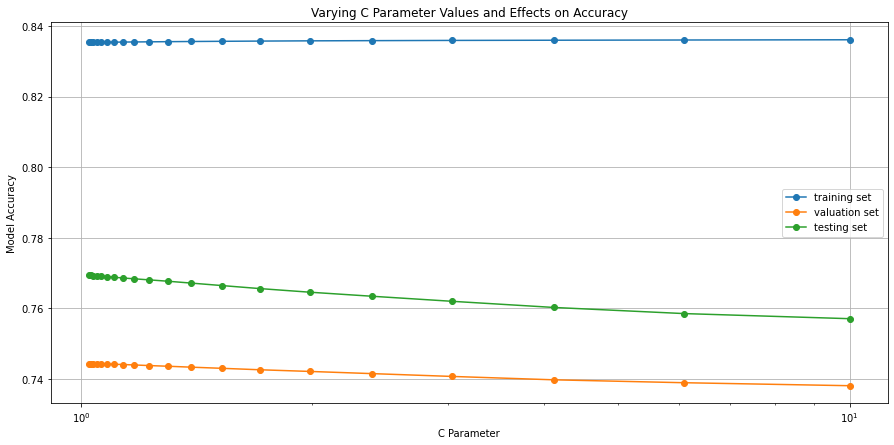

In [68]:
#plotting the values
plt.rcParams["figure.figsize"] = (15,7)
plt.semilogx(10**(np.array(values)), train_AUC, label="training set", marker="o")
plt.semilogx(10**(np.array(values)), value_AUC, label="valuation set", marker="o")
plt.semilogx(10**(np.array(values)), test_AUC, label="testing set", marker="o")
plt.xlabel ("C Parameter")
plt.ylabel ("Model Accuracy")
plt.title ("Varying C Parameter Values and Effects on Accuracy")
plt.legend()
plt.grid(x)
plt.show()


### Answer
Comment on the trends. Do you see evidence of overfitting? Explain. For the rest of this assignment, use the model with the highest AUC on the validation set.

Looking at the trends in the above plot, we can see that training accuracy increases as the C parameter increases (up until it plateaus around an accuracy of 0.82), but this is not the case for testing set and valuation set accuracy. The testing set accuracy maxes out around 10^-1.4 and for the valuation set around 10^-1.2. This is eveidence of overfitting. As the training model accuracy increases, the testing set and training set accuracy decreases. 

In [75]:
#finding the highest auc value
print ("This is the max accuracy in the valuation set:", max(value_AUC))
i = value_AUC.index(max(value_AUC))
c_value = 10**(np.array(values))[i]
print ("This is the c_value assocaited with the higheest accuracy in the valuation set:",c_value)

This is the max accuracy in the valuation set: 0.7444067465531234
This is the c_value assocaited with the higheest accuracy in the valuation set: 1.023292992280754


g. Assess model *calibration* on the test set. This checks whether the model's predicted probabilities line up with the true probabilities, and is important to assess here because we will be analyzing the model's predicted probabilities. To assess calibration, take the 10% of rows of the test set with the highest model predictions and compare the mean model predicted probability (ie, the output of `predict_proba`) to the actual mean of the outcome variable. Repeat for the next 10% of rows, and for all 10% groups. Make a plot comparing the model predicted probabilities on each 10% group to the actual outcomes (mean predicted probability on the x-axis and mean actual outcome on the y-axis). You should end up with a plot with 10 points, one for each 10% group. Plot the line y=x so you can see how well the predicted probabilities line up with the actual probabilities - ideally, your points will lie on the line or close to it. (10 points)

Calibration is an issue for many machine learning models, including deep learning models, so this is always a good thing to check. In a full analysis, it would make sense to check calibration (and AUC) for subgroups as well (eg, each race group).

In [103]:
# set logistic regression and fit to model
lr = LogisticRegression(C=c_value, penalty='l1', solver='liblinear')
lr.fit(sqf_X_train, train_y_weapon)

# generating probabilities
prob_weapon_test = lr.predict_proba(sqf_X_test)

# new series with the probabilites
test_y_predic = pd.Series(prob_weapon_test[:, 1], index=test_y_weapon.index)
test_y_predic.name = "prediction"

# check: show series
test_y_predic.head()

1488     0.016167
32607    0.020389
30208    0.035816
8324     0.024337
32384    0.016189
Name: prediction, dtype: float64

In [104]:
# copy found weapon col 
test_y_weapon_predic = test_y_weapon.copy()

# concact with predictions
test_y_weapon_predic = pd.concat([test_y_weapon, test_y_predic], axis=1)

# check: print head 
test_y_weapon_predic.head()

,found_weapon,prediction
1488,False,0.016167
32607,False,0.020389
30208,False,0.035816
8324,False,0.024337
32384,False,0.016189


In [106]:
# sort values by prediction rate
test_y_weapon_predic_sorted = test_y_weapon_predic.sort_values(by='prediction', ascending=False)

# check print head
test_y_weapon_predic_sorted.head()

,found_weapon,prediction
3127,True,0.954169
28395,False,0.953293
8409,False,0.928964
34870,True,0.925634
27906,False,0.872683


In [117]:
# set empty lists and minimum count to zero
means = []
predic_probabilities = []
min_count = 0

# takes 10% from total shape and round
parts = round(test_y_predic_sorted.shape[0] / 10)

# loop over 10 parts and calc mean of predicitions, and append to list
for i in range(10):
    times = i+1
    
    # if last count, start the subset not * times
    if i == 9:
        subset = test_y_predic_sorted[start:]
    else:
        subset = test_y_predic_sorted[start:parts*times]
    
    # take mean from subset predictions and found weapons
    predic = subset["prediction"].mean()
    mean = subset["found_weapon"].mean()
    
    # append to list
    means.append(mean)
    predic_probabilities.append(predic)
    
    # set minimium count for next 10% 
    min_count+= parts
    

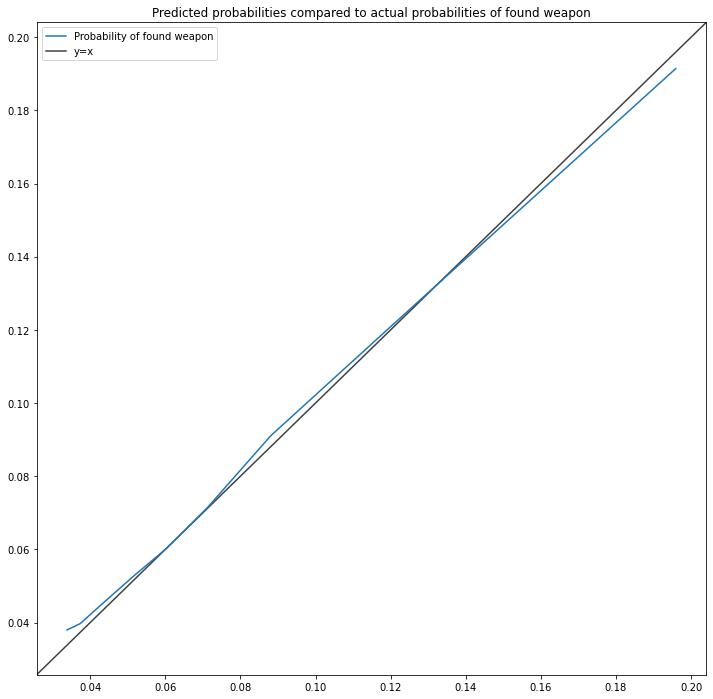

In [126]:
# plot means and prob and lims

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(predic_probabilities, means, label="Probability of found weapon")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="y=x")
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title ("Predicted probabilities compared to actual probabilities of found weapon")

ax.legend()

h. Using the test set, compute the fraction of observations which have lower than a 2% model-predicted probability of finding a weapon for Black, Hispanic, and white pedestrians. Stops below this threshold are extremely unlikely to have resulted in finding a weapon, arguably violating the Fourth Amendment. Repeat this for 20 thresholds evenly spaced between 1% and 5%. Make a graph where the x-axis is the threshold, and the y-axis is the fraction of stops falling below that threshold, with one line for each race group. Explain what you observe. Do you think this graph provides evidence for Fourteenth Amendment violations (racial discrimination)? (10 points)

In [156]:
# WIP 🛶

# set test set with race from initial cleaned data
test_y_race = sample_data_dropped["suspect_race"].loc[test_indexes]

# function to calculate fraction of probability
def fracProbaCalc(threshold, race, pri):
    
    # calc total stops per race
    total_stops = test_y_race[test_y_race == race].shape[0]
    
    # filter if predictions are lower than threshold
    results = test_y_predic_sorted[test_y_predic_sorted["prediction"] < threshold]
    
    # set index to initial data
    index = results.index
    suspect_race = sample_data_dropped.loc[index, 'suspect_race']
    
    # calulate  fraction
    total_race = suspect_race[suspect_race == race].shape[0]
    fraction = total_race / total_stops

    # print results if print set true
    if pri:
        print(race, "stops under", threshold, "threshold:", fraction)
    else:
        return fraction

fracProbaCalc(0.02, "black", True)
fracProbaCalc(0.02, "white", True)
fracProbaCalc(0.02, "hispanic", True)

black stops under 0.02 threshold: 0.6932710677138612
white stops under 0.02 threshold: 0.3881578947368421
hispanic stops under 0.02 threshold: 0.5616750113791534


In [157]:
# calc steps for 20 thresholds evenely spaced between 1% and 5%
steps = np.linspace(0.01, 0.05, 20, endpoint=True)

# check: print
print(steps)

[0.01       0.01210526 0.01421053 0.01631579 0.01842105 0.02052632
 0.02263158 0.02473684 0.02684211 0.02894737 0.03105263 0.03315789
 0.03526316 0.03736842 0.03947368 0.04157895 0.04368421 0.04578947
 0.04789474 0.05      ]


In [161]:
total_black_stops = test_y_race[test_y_race == 'black'].shape[0]
total_white_stops = test_y_race[test_y_race == 'white'].shape[0]
total_hispanic_stops = test_y_race[test_y_race == 'hispanic'].shape[0]

black_stops = []
white_stops = []
hispanic_stops = []

# loop through all steps
for step in steps:
    # append fractions to lists
    black_stops.append(fracProbaCalc(step, "black", False))
    white_stops.append(fracProbaCalc(step, "white", False))
    hispanic_stops.append(fracProbaCalc(step, "hispanic", False))
    
#     sub_results = test_y_predic_sorted[y_test_results.pred < step]
    
#     relevant_index = sub_results.index
#     relevant_race = df_all.loc[relevant_index, 'suspect_race']
#     total_black = relevant_race[relevant_race == 'black'].shape[0]
#     total_white = relevant_race[relevant_race == 'white'].shape[0]
#     total_hispanic = relevant_race[relevant_race == 'hispanic'].shape[0]

#     black_stops.append(total_black / total_black_stops)
#     white_stops.append(total_white / total_white_stops)
#     hispanic_stops.append(total_hispanic / total_hispanic_stops)

[0.3837826363829336, 0.4720866058161749, 0.5434090426661006, 0.6015707917639567, 0.66079388664827, 0.7032477181065592, 0.7378475907450648, 0.7656548503502442, 0.7907026109106347, 0.8068350668647846, 0.8231797919762258, 0.8414349395032902, 0.8577796646147314, 0.8726385056251327, 0.8836765018042878, 0.8962003820844832, 0.9044788792188495, 0.9144555296115474, 0.9201867968584164, 0.9252812566334112]


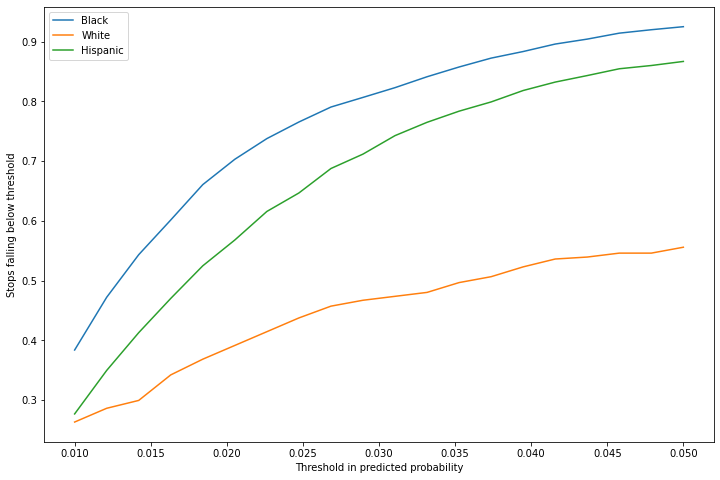

In [167]:
# plot graph 
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(steps, black_stops, label="Black")
ax.plot(steps, white_stops, label="White")
ax.plot(steps, hispanic_stops, label="Hispanic")

ax.set_xlabel("Threshold in predicted probability")
ax.set_ylabel("Stops falling below threshold")

ax.legend()

# Analyze: now writing !

i. The analysis you have performed in the second part of this assignment is very similar to the analysis in [this paper](https://5harad.com/papers/stop-and-frisk.pdf). Read the paper and write a few sentences about their main conclusions. (5 points)

# Analyze: now writing !